# \<center\>Applying ICA to HD 189733

In [73]:
# Before anything, import relevant modules
%load_ext autoreload
%autoreload 2
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
sys.path.append(os.getcwd()+'/ICA') # to use personal ICA package
from utils import SNR, standardize, plot_2D_distrib, mean, whiten
from core import CustomICA, PostProcess
from heuristics import sk_FastICA, jadeR, V_manifold_optim, A_manifold_const, FOBI, partial_FastICA, PCA
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data pre-processing

In [74]:
planet = 'HD189733'
period = 2.218573

In [75]:
os.listdir('data/'+planet)

['Log_HD189733.dat',
 'Log_HD189733.xlxs.dat',
 'SOPHIE.2007-06-09T01_19_05.904_ccf_G2_A.csv',
 'SOPHIE.2007-06-09T01_19_05.904_ccf_G2_A.tbl',
 'SOPHIE.2007-06-13T01_59_57.950_ccf_G2_A.tbl',
 'SOPHIE.2007-07-13T00_09_04.019_ccf_G2_A.tbl',
 'SOPHIE.2007-07-16T20_50_11.200_ccf_G2_A.tbl',
 'SOPHIE.2007-07-17T02_24_01.489_ccf_G2_A.tbl',
 'SOPHIE.2007-07-17T20_17_47.439_ccf_G2_A.tbl',
 'SOPHIE.2007-07-18T02_31_34.642_ccf_G2_A.tbl',
 'SOPHIE.2007-07-18T20_23_18.276_ccf_G2_A.tbl',
 'SOPHIE.2007-07-19T02_40_21.744_ccf_G2_A.tbl',
 'SOPHIE.2007-07-19T20_37_03.017_ccf_G2_A.tbl',
 'SOPHIE.2007-07-20T01_39_08.899_ccf_G2_A.tbl',
 'SOPHIE.2007-07-20T01_45_18.399_ccf_G2_A.tbl',
 'SOPHIE.2007-07-20T01_51_38.556_ccf_G2_A.tbl',
 'SOPHIE.2007-07-20T01_58_06.728_ccf_G2_A.tbl',
 'SOPHIE.2007-07-20T02_04_32.239_ccf_G2_A.tbl',
 'SOPHIE.2007-07-20T21_13_04.357_ccf_G2_A.tbl',
 'SOPHIE.2007-07-21T02_19_17.827_ccf_G2_A.tbl',
 'SOPHIE.2007-07-21T20_29_45.906_ccf_G2_A.tbl',
 'SOPHIE.2007-07-21T21_55_30.310_ccf_G2_A

In [76]:
# First step: read data from data subdirectory
# keep only columns with time stamps and errors
metadata = pd.read_csv('data/'+planet+'/Log_'+planet+'.dat', sep='\s+', usecols=['#', 'File', 'Name', 'Date', '(MJD)'])
metadata.columns = ['File Name', 'Date (MJD)', 'Phase', 'RV obs', 'RV theo']
metadata.drop_duplicates(inplace=True)


In [77]:
metadata

,File Name,Date (MJD),Phase,RV obs,RV theo
0,2007-06-09T01_19_05.904,54260.053056,-9.261613,-2.2724,-0.0149
1,2007-06-13T01_59_57.950,54264.081470,-7.445847,-2.4420,-0.1932
2,2007-07-13T00_09_04.019,54294.002581,6.040783,-2.0664,0.1983
3,2007-07-16T20_50_11.200,54297.864479,7.781494,-2.2063,0.0403
4,2007-07-17T02_24_01.489,54298.096308,7.885989,-2.0992,0.1546
...,...,...,...,...,...
58,2007-08-23T23_06_55.822,54335.959421,24.952394,-2.0569,0.1959
59,2009-06-21T02_07_31.731,55003.083102,325.651483,-2.3503,-0.1189
60,2009-07-20T02_14_35.563,55032.088009,338.725144,-2.2838,-0.0319
61,2009-07-28T21_55_29.751,55040.908090,342.700704,-2.3068,-0.0625


## 

In [78]:
metadata['Date (MJD)']

0     54260.053056
1     54264.081470
2     54294.002581
3     54297.864479
4     54298.096308
          ...     
58    54335.959421
59    55003.083102
60    55032.088009
61    55040.908090
62    55091.893322
Name: Date (MJD), Length: 63, dtype: float64

In [79]:
timeline = np.array(metadata['Date (MJD)'])

In [80]:
timeline

array([54260.053056, 54264.08147 , 54294.002581, 54297.864479,
       54298.096308, 54298.841979, 54299.101551, 54299.84581 ,
       54300.10765 , 54300.855347, 54301.065139, 54301.069421,
       54301.073819, 54301.07831 , 54301.082778, 54301.880359,
       54302.086065, 54302.849595, 54302.909132, 54303.061296,
       54303.108449, 54303.879271, 54305.034421, 54305.861574,
       54306.074225, 54306.099965, 54306.860822, 54306.988576,
       54307.076551, 54307.863808, 54308.088646, 54308.894016,
       54309.006053, 54309.924144, 54310.101887, 54310.89515 ,
       54311.064155, 54311.889792, 54312.037998, 54313.023773,
       54313.111285, 54313.870023, 54315.059213, 54315.886134,
       54316.061192, 54316.988067, 54317.12088 , 54317.823391,
       54318.06309 , 54327.887731, 54328.031319, 54329.828646,
       54330.854387, 54331.047986, 54331.976146, 54332.84669 ,
       54333.888738, 54334.892488, 54335.959421, 55003.083102,
       55032.088009, 55040.90809 , 55091.893322])

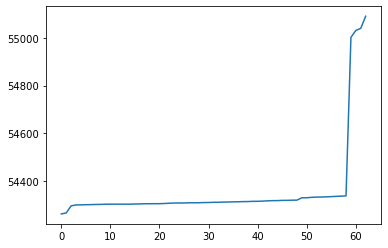

In [81]:
plt.plot(timeline)

In [82]:
obs = standardize(np.array(metadata['RV obs']))
theo = standardize(np.array(metadata['RV theo']))
help(standardize)

Help on function standardize in module utils:

standardize(signal)



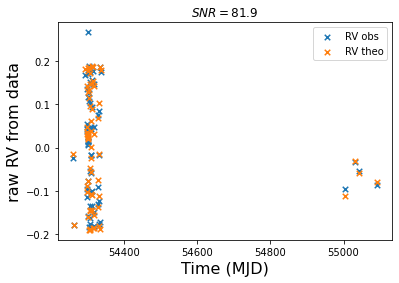

In [83]:
# And see what we made
plt.figure()
plt.scatter(timeline, obs, marker='x', s=30, label='RV obs')
plt.scatter(timeline, theo, marker='x', s=30,label='RV theo')
plt.xlabel('Time (MJD)', fontsize=16)
plt.ylabel('raw RV from data', fontsize=16)
plt.title(r'$SNR='+'{:.1f}'.format(SNR(theo, obs))+'$')
plt.legend()
plt.show()

In [84]:
n = len(timeline)
d = 39 # number of orders used

print("Working with n =",n,"time measures and d =",d,"spectral dimensions")

rv = []
sigma = []

for i, raw in metadata.iterrows():
    df = pd.read_csv('data/'+planet+'/SOPHIE.'+raw['File Name']+'_ccf_G2_A.tbl', 
                     sep='\s+', 
                     skiprows=[1,], 
                     index_col='order')
    rv.append(list(df['RV']))
    sigma.append(list(df['sig']))
    # print(df)
    # print(i)
    # print(raw)
    # print(rv)
    # print(sigma) 
    
rv = np.array(rv).T
sigma = np.array(sigma).T
assert rv.shape == (d, n)

Working with n = 63 time measures and d = 39 spectral dimensions


The SOPHIE listings contain a lot of informataion on the observations of a given target. Let's take a look at the available columns.

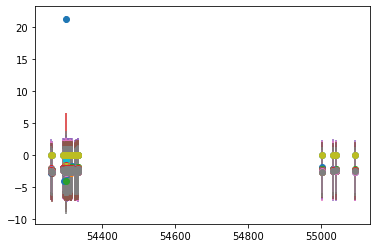

In [85]:
for order in range(d):
    plt.errorbar(timeline, rv[order,:], sigma[order,:], fmt='o')

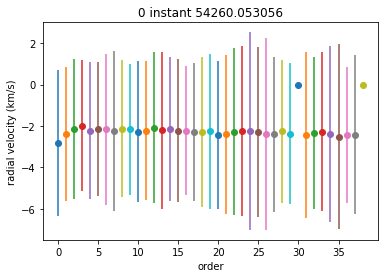

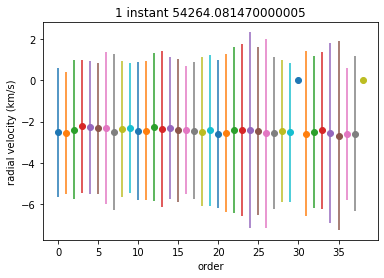

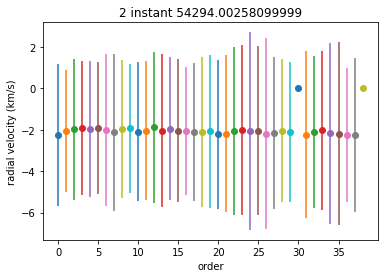

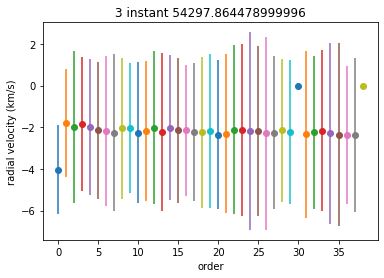

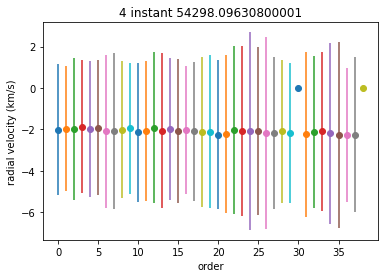

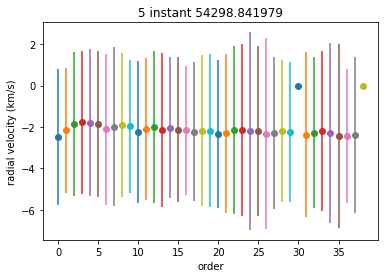

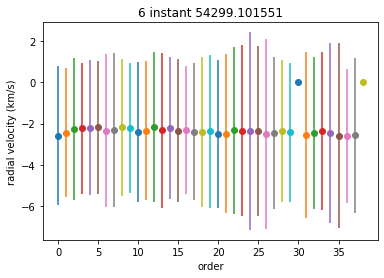

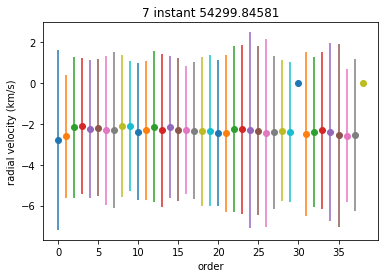

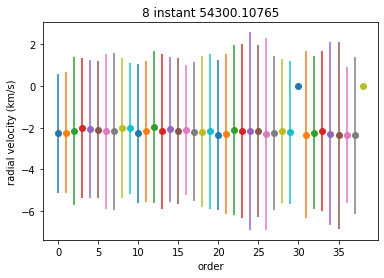

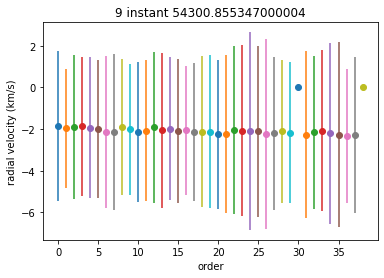

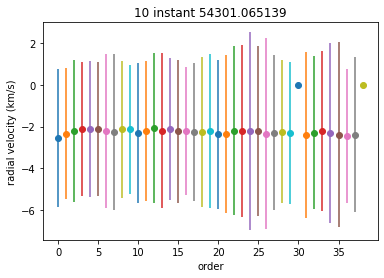

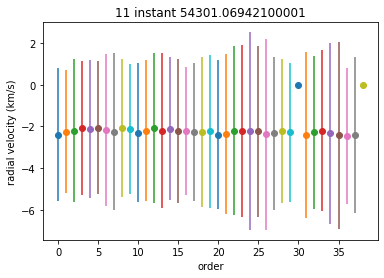

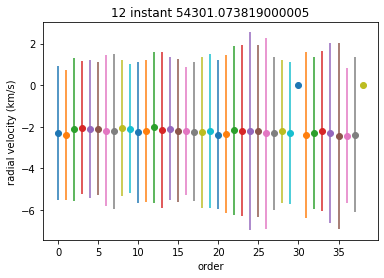

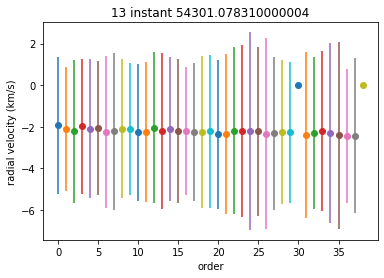

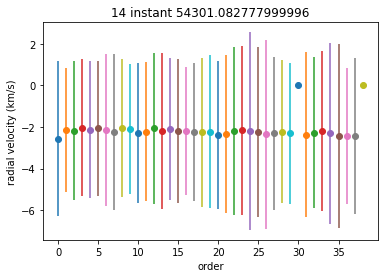

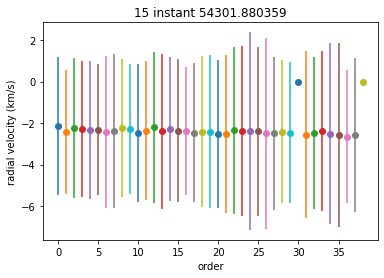

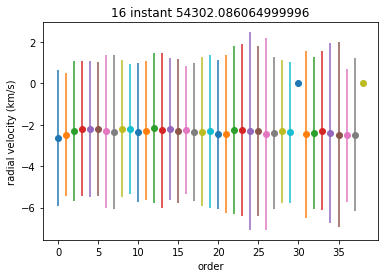

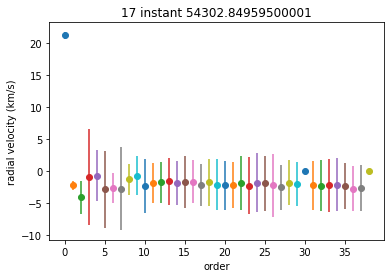

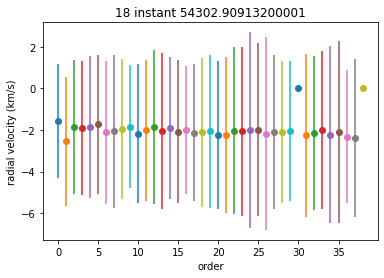

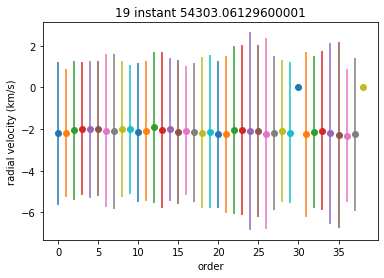

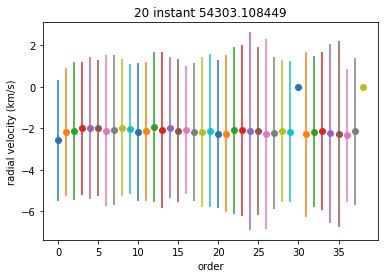

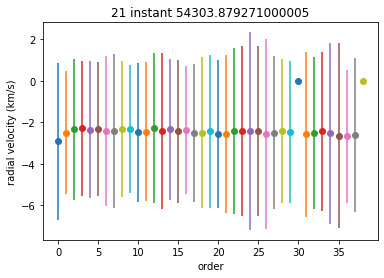

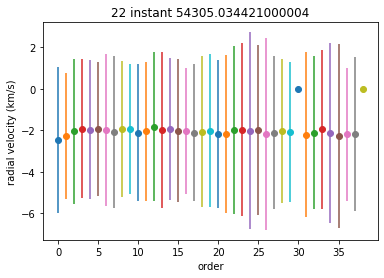

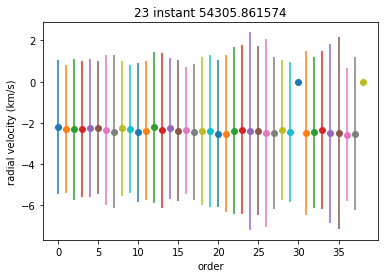

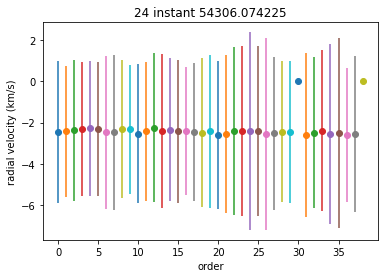

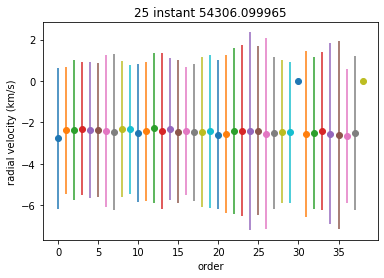

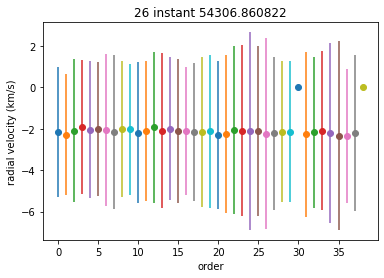

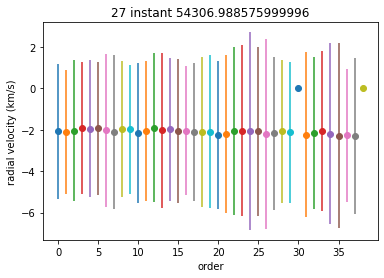

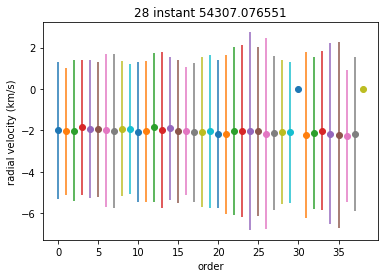

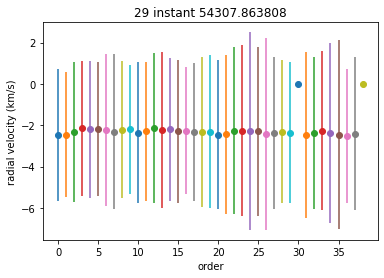

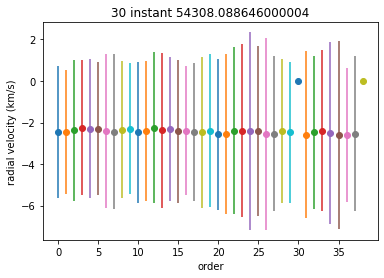

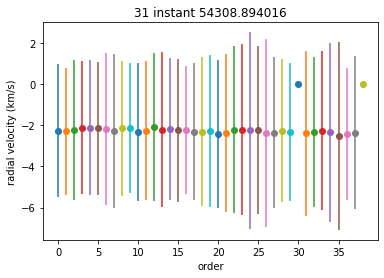

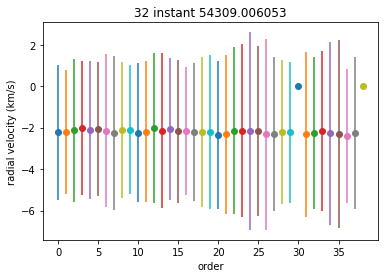

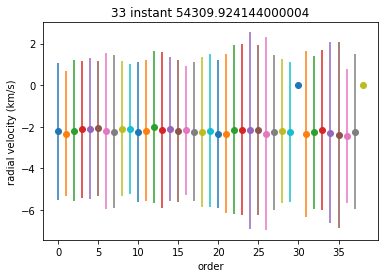

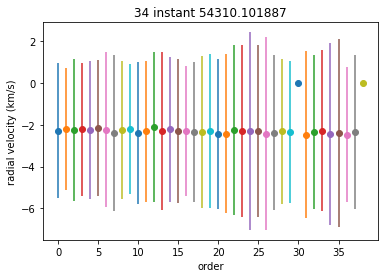

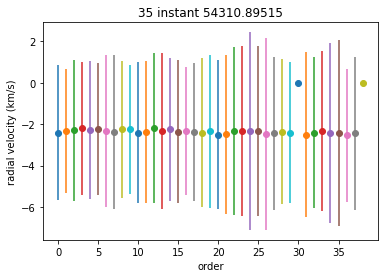

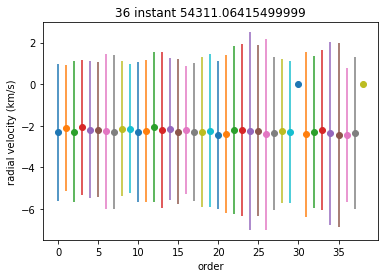

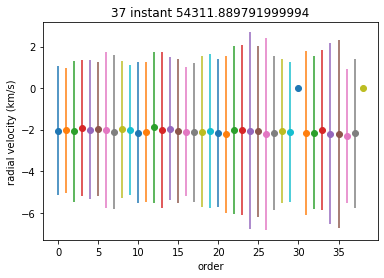

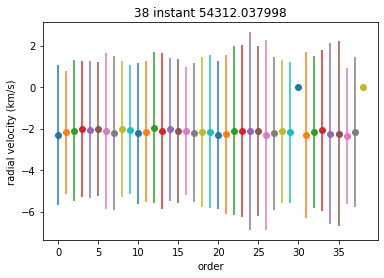

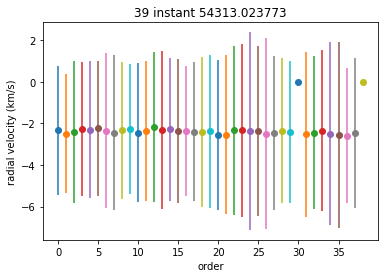

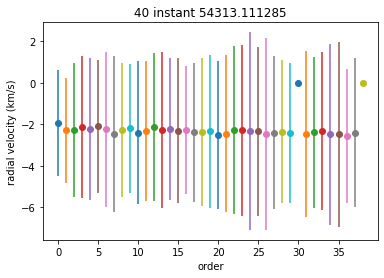

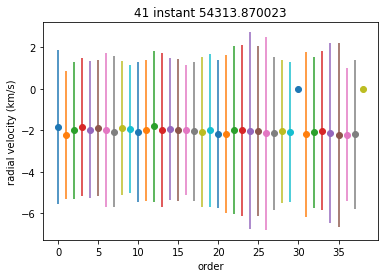

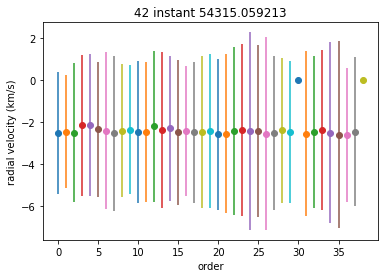

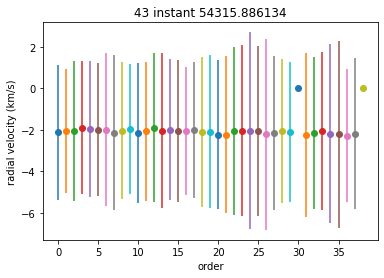

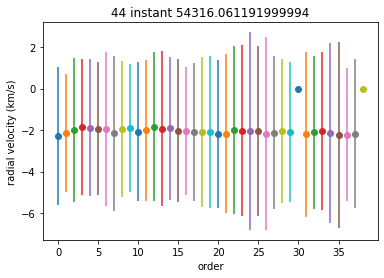

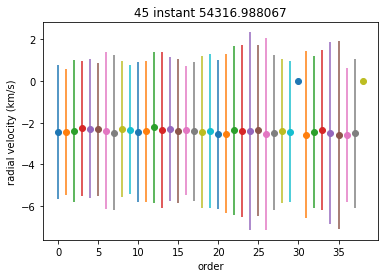

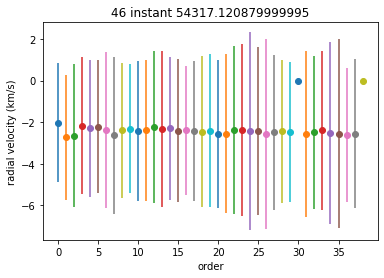

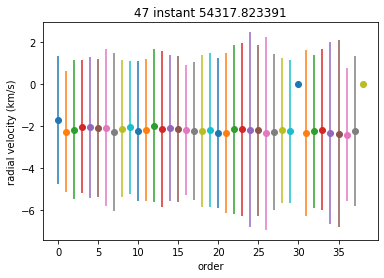

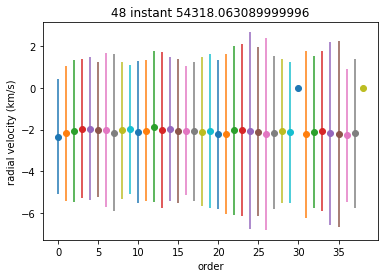

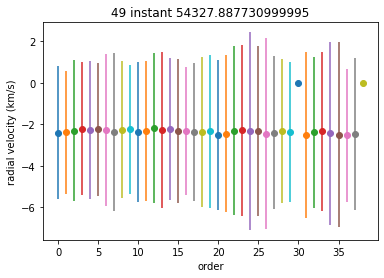

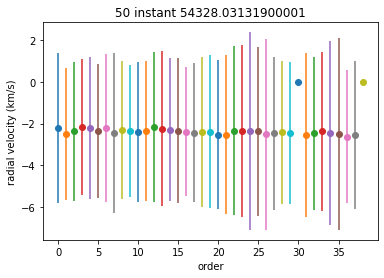

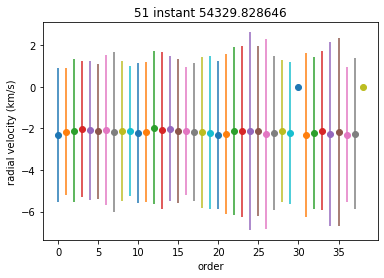

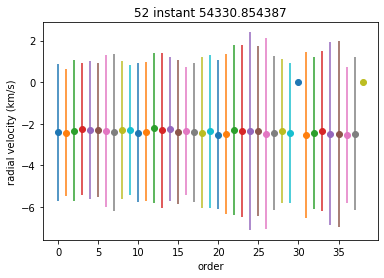

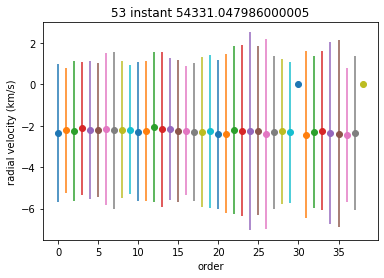

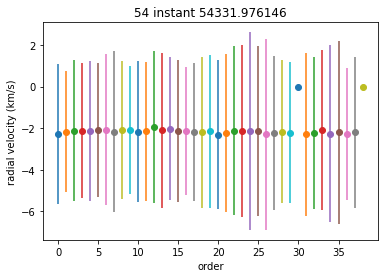

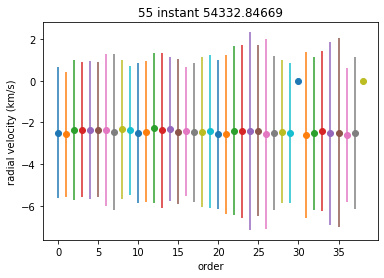

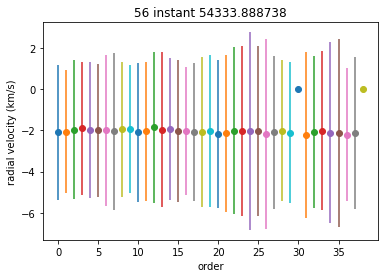

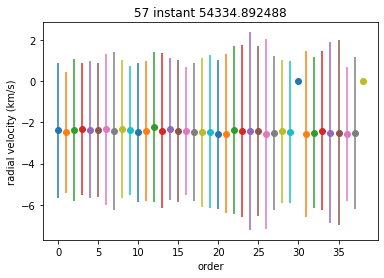

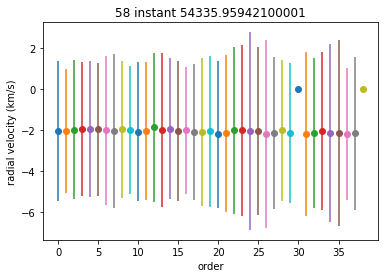

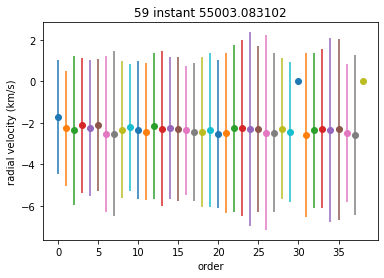

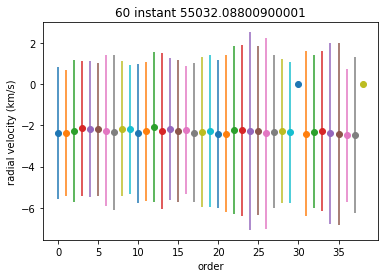

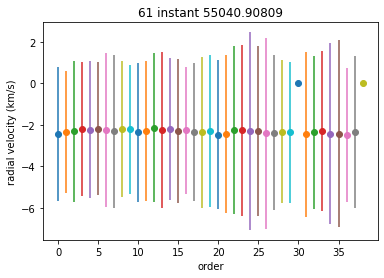

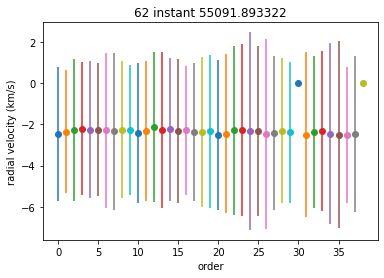

In [86]:
for instant in range(n):
    plt.figure()
    for order in range(d):
        
        plt.title(str(instant )+ ' instant '+str(timeline[instant]))
        plt.xlabel('order')
        plt.ylabel('radial velocity (km/s)')
        plt.errorbar(order, rv[order, instant], sigma[order, instant], fmt='o')
    plt.show()

We can see that order n°30 and n°38 gives wrong data, so we will delete them in the following.

<ErrorbarContainer object of 3 artists>

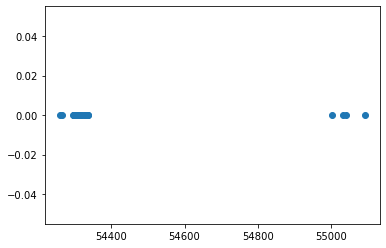

In [87]:
plt.errorbar(timeline, rv[30,:], sigma[30,:], fmt='o')

<ErrorbarContainer object of 3 artists>

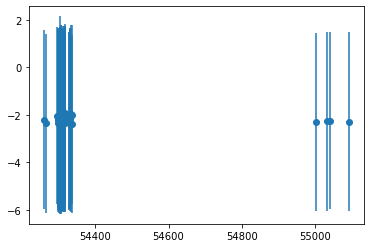

In [88]:
plt.errorbar(timeline, rv[13,:], sigma[13,:], fmt='o')

<ErrorbarContainer object of 3 artists>

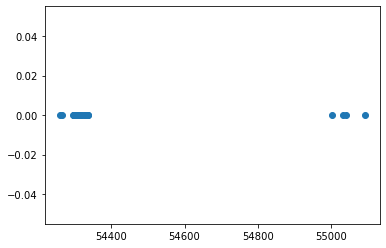

In [89]:
plt.errorbar(timeline, rv[38,:], sigma[38,:], fmt='o')

In [90]:
rv = np.delete(rv, [30, 38], 0)
sigma = np.delete(sigma, [30, 38], 0)

In [91]:
d, n = rv.shape
print("Working with n =",n,"time measures and d =",d,"spectral dimensions")

Working with n = 63 time measures and d = 37 spectral dimensions


Moreover, at instant n°17, order 0 raises an wrong value. Since it is the only time it fails, we are going to keep order 0 but replace this single error by the average value computed with other orders:

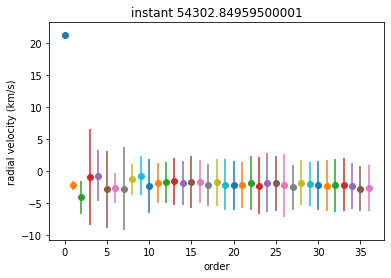

In [92]:
instant = 17
plt.figure()
for order in range(d):
        
    plt.title('instant '+str(timeline[instant]))
    plt.xlabel('order')
    plt.ylabel('radial velocity (km/s)')
    plt.errorbar(order, rv[order, instant], sigma[order, instant], fmt='o')
plt.show()

In [93]:
ind = np.ones(len(timeline), dtype=bool)
ind[3] = False
ind[17] = False

print(theo[ind][60
               ])

-0.07963079994793948


In [94]:
# Select times in the big set
ind *= (timeline > 54280) & (timeline < 54350)

t = timeline[ind]

print('There are {} points in the big set.'.format(sum(ind)))

There are 55 points in the big set.


In [95]:
rv = rv[:,ind]
sigma = sigma[:,ind]

d, n = rv.shape
print("Working with n =",n,"time measures and d =",d,"spectral dimensions")

Working with n = 55 time measures and d = 37 spectral dimensions


In [96]:
rv = mean(rv)[0]
print(len(rv))
print('rv centered')
a,b = rv.shape
print(a,b)
help(mean)

37
rv centered
37 55
Help on function mean in module utils:

mean(X)
    Returns: X (d,n) and X_av (d,) such that 
    X is finally zero meaned over time (axis 1)



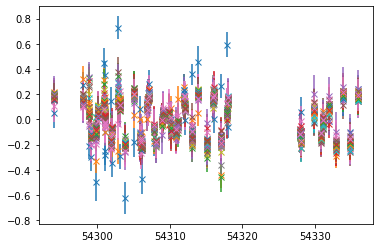

In [97]:
for order in range(d):
    plt.errorbar(t, rv[order,:], sigma[order,:]/30, fmt='x')

> **Important**. There is something here. The majority of data span only 40 days. This may be a problem to correctly sample the activity signal. These data set may not be the best to perform ICA.

For now, let's keep only those ~40 days of data.

# PCA

(37, 37)


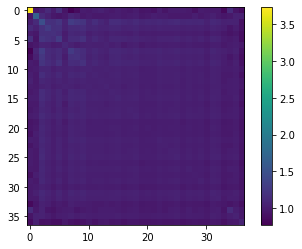

In [98]:
img = plt.imshow(rv.dot(rv.T))
plt.colorbar(img)
print((rv.dot(rv.T)).shape)

In [99]:
rv_w, Whiten_mat, Whiten_mat_inv, eigs_RY_2 = whiten(rv)

In [100]:
eigs_RY_2 /= np.sum(eigs_RY_2)

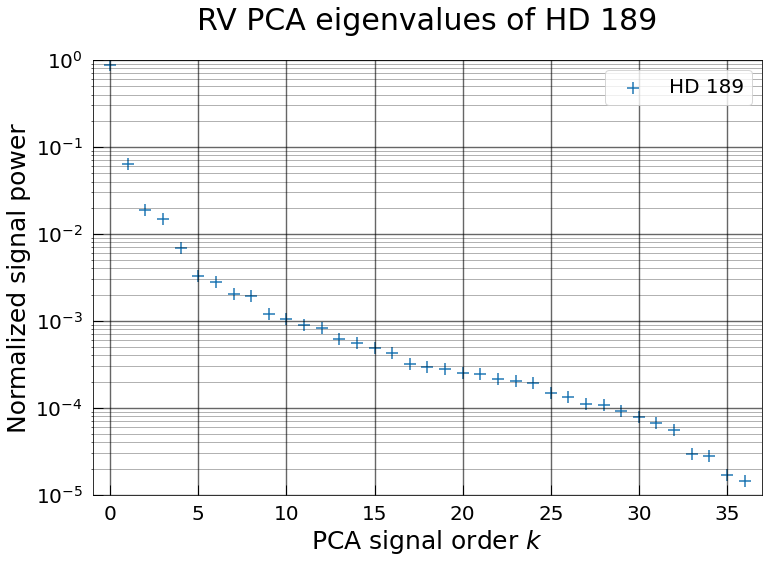

In [101]:
plt.figure(figsize=(12,8))
plt.yscale('log')
plt.grid(True, which='minor', linewidth=0.5, color='black', alpha=0.6)
plt.grid(True, which='major', linewidth=1.4, color='black', alpha=0.6)
plt.ylim((10**-5, 10**0))
plt.xlim(-1,37)
plt.scatter(range(len(rv_w)), eigs_RY_2, marker='+', s=150, linewidths=1, label='HD 189', alpha=1)
plt.tick_params(length=10, width=1, direction='in', pad=10, labelsize=20)
plt.legend(fontsize=20)
plt.xlabel(r'PCA signal order $k$', fontsize=25)
plt.ylabel(r'Normalized signal power', fontsize=25)
plt.title(r'RV PCA eigenvalues of HD 189', fontsize=30, pad=30)
#plt.savefig('PCA_HD189_eigenvalues.png', dpi=200)
plt.show()

Let us build some proxies for the $RV_{theo}$:
- $AVG$: the averaged radial velocity over all the orders
- $PCA_1$: the main component raised by PCA:
$$PCA_1 = \alpha . RV_w[0,:]$$
$$Cov(PCA_1, RV_{theo}) = Var(RV_{theo}) \iff \alpha . Cov(RV_w[0,:], RV_{theo})=Var(RV_{theo}) \iff \alpha = \frac{Var(RV_{theo})}{Cov(RV_w[0,:], RV_{theo})}$$

In [102]:
obs_avg = np.average(rv, axis=0)
alpha = np.array(metadata['RV theo'])[ind].dot(np.array(metadata['RV theo'])[ind]) \
        * 1 / rv_w[0,:].dot(np.array(metadata['RV theo'])[ind])
PCA1 = rv_w[0,:]*alpha

#Plus lisible mais en décomposant le calcul c'est moins précis 

Text(0, 0.5, 'RV averaged over orders')

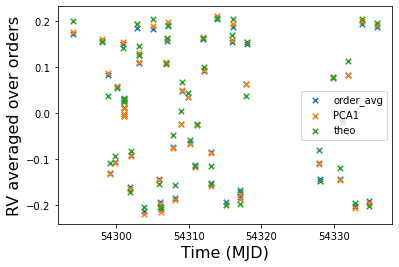

In [103]:
# And plot them
plt.figure()
plt.scatter(t, obs_avg, marker='x', s=30, label='order_avg')
plt.scatter(t, PCA1, marker='x', s=30, label='PCA1')
plt.scatter(t, np.array(metadata['RV theo'])[ind], marker='x', s=30, label='theo')
plt.legend()
plt.xlabel('Time (MJD)', fontsize=16)
plt.ylabel('RV averaged over orders', fontsize=16)

In [104]:
SNR(standardize(theo[ind]), standardize(obs_avg))

74.77094126582581

In [105]:
SNR(standardize(theo[ind]), standardize(PCA1))

73.17702751214455

## Study of the Hope Limit

A simple expression of the upper bound of the best signal candidate that could be found in the output of ICA, when given an input data $X_1, \dots,X_r$ is:

\begin{equation}
\text{HopeLim} (X_1, \dots, X_r) = \sup_{Y \in \text{Vect}(X_1, \dots, X_r)} \text{SNR}(RV_{pl}, Y)
\end{equation}

If we use all the dimensions we have:

In [106]:
sol = minimize(lambda combs: np.sum((combs.dot(rv)-standardize(theo[ind]))**2), np.ones(len(rv)))
print('\nHopeLim =', SNR(standardize(theo[ind]), sol.x.dot(rv)))


HopeLim = 525.2440341119257


We can try to reduce the dimension and look for the variations of HopeLim

In [107]:
def random_dim_reductor(d, d_out):
    red = np.zeros((d_out, d))
    if not (d//d_out)*d_out == d:
        resid = d - (d//d_out)*d_out
        d -= resid
        print('Warning: cropping ', resid,' sources')
    choices = np.random.choice(range(d), (d_out,d//d_out), replace=False)
    for row in range(d_out):
        red[row, choices[row]] = 1
    return red

def avg_dim_reductor(d, d_out):
    red = np.zeros((d_out, d))
    for row in range(d_out):
        red[row, row*(d//d_out):(1+row)*(d//d_out)] = 1
    return red

In [108]:
avg_dim_reductor(10,5)

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]])

First let's look at an example when reducting to 6 dimensions using neighbour-grouping:

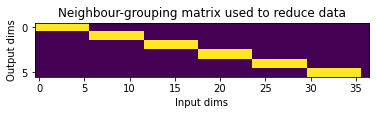

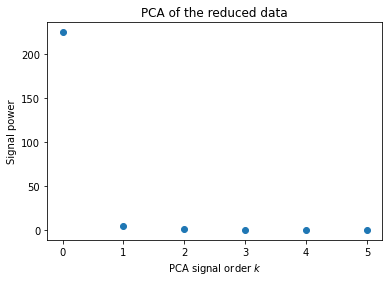


HopeLim = 139.695734852109
PCA_red1 = 70.93409726625522


In [109]:
d_out = 6
  
red = avg_dim_reductor(d, d_out)
plt.figure()
plt.title('Neighbour-grouping matrix used to reduce data')
plt.xlabel('Input dims')
plt.ylabel('Output dims')
plt.imshow(red)
plt.show()

rv_w, Whiten_mat, Whiten_mat_inv, eigs_RY_2 = whiten(red.dot(rv))
plt.figure()
plt.title('PCA of the reduced data')
plt.scatter(range(len(rv_w)), eigs_RY_2)
plt.xlabel(r'PCA signal order $k$')
plt.ylabel(r'Signal power')
plt.show()
sol = minimize(lambda combs: np.sum((combs.dot(rv_w)-standardize(theo[ind]))**2), np.ones(len(rv_w)))
print('\nHopeLim =', SNR(standardize(theo[ind]), sol.x.dot(rv_w)))
print('PCA_red1 =', SNR(standardize(theo[ind]), standardize(np.sign(standardize(theo[ind]).dot(rv_w[0,:]))*rv_w[0,:])))



HopeLim = 75.02177995625199
PCA_red 1= 74.77094126582573


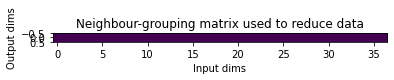

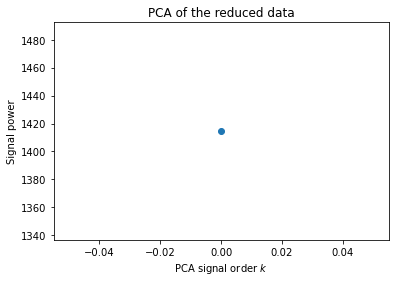


HopeLim = 124.09591548561855
PCA_red 2= 71.68241213655658


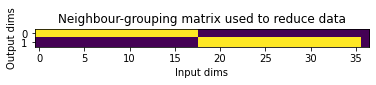

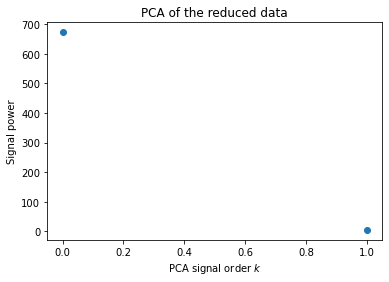


HopeLim = 127.88244479487608
PCA_red 3= 71.26707546273994


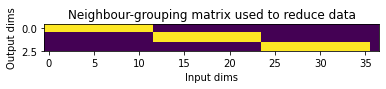

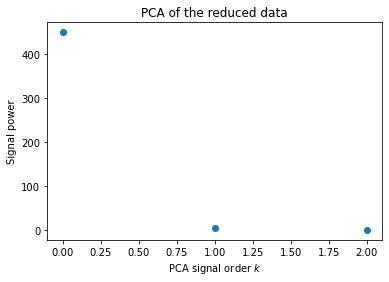


HopeLim = 135.42261187034734
PCA_red 4= 71.16709488860094


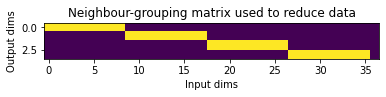

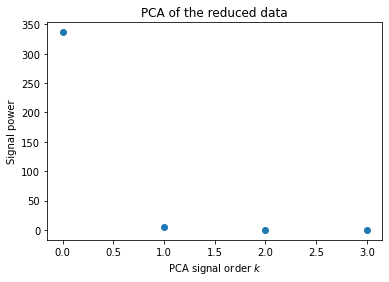


HopeLim = 140.82360510172637
PCA_red 5= 67.90853826947166


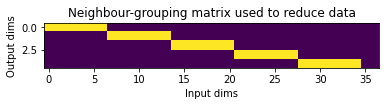

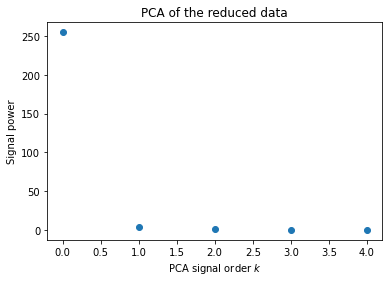


HopeLim = 139.695734852109
PCA_red 6= 70.93409726625522


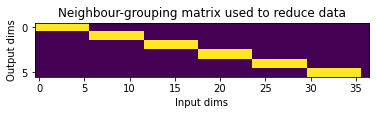

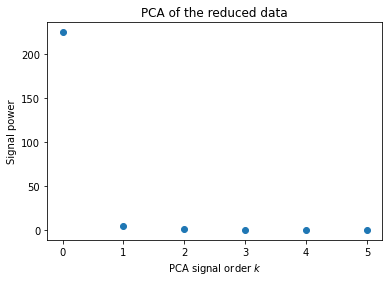


HopeLim = 137.94035440571207
PCA_red 7= 67.68413390579465


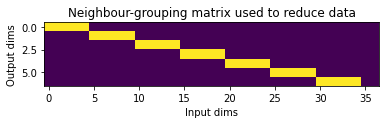

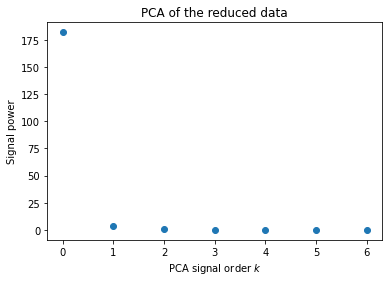


HopeLim = 134.0100828948245
PCA_red 8= 59.135667359511636


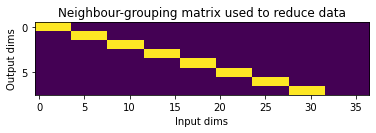

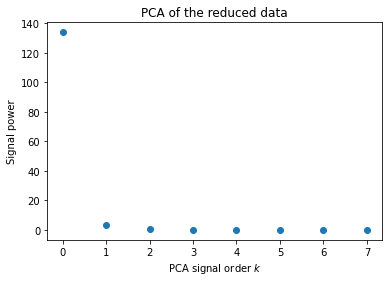


HopeLim = 143.4985239027248
PCA_red 9= 70.8460240135122


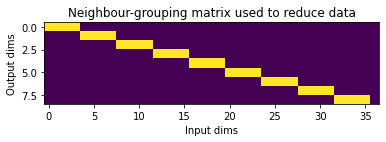

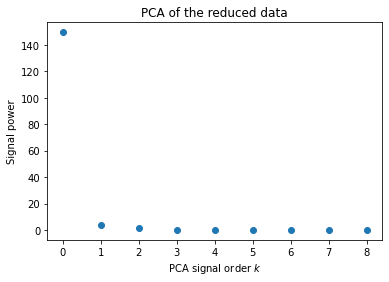


HopeLim = 145.0316910286419
PCA_red 10= 55.38651997272208


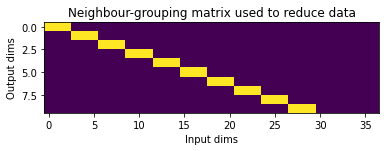

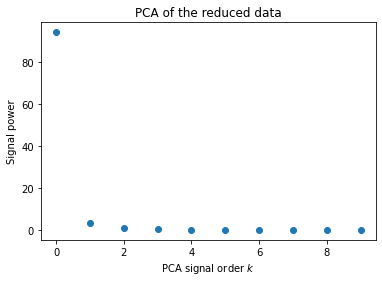


HopeLim = 146.45935003957106
PCA_red 11= 61.72074075042055


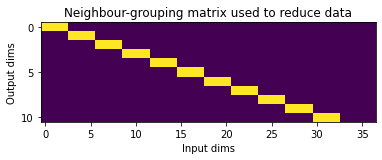

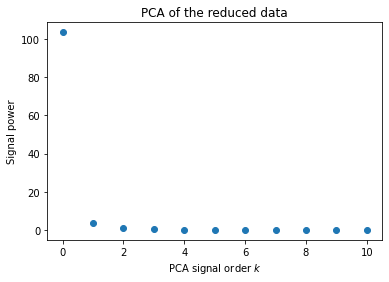


HopeLim = 153.70285003898448
PCA_red 12= 70.87020904951879


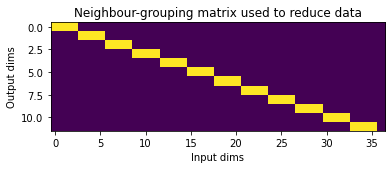

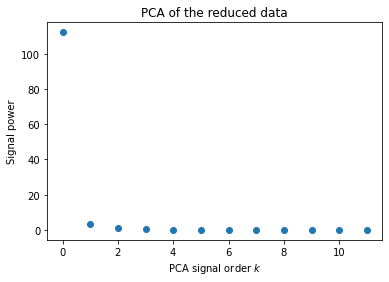


HopeLim = 155.9867351682324
PCA_red 13= 46.48497213754625


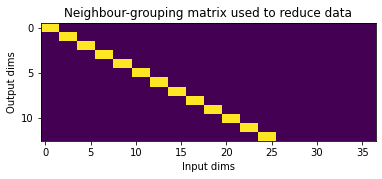

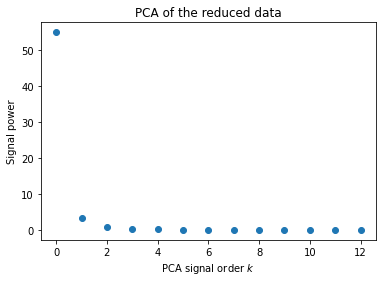


HopeLim = 156.6274045689056
PCA_red 14= 50.810152378009505


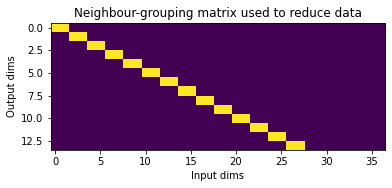

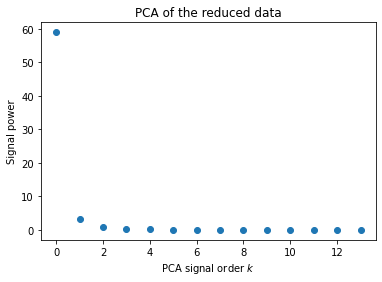


HopeLim = 158.2424952192471
PCA_red 15= 55.68487755381451


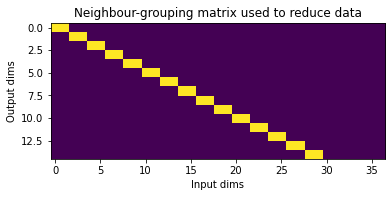

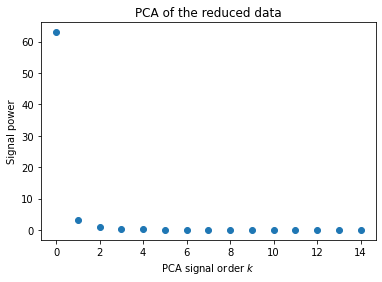


HopeLim = 158.51610865632725
PCA_red 16= 59.47436223089628


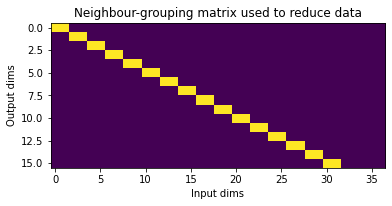

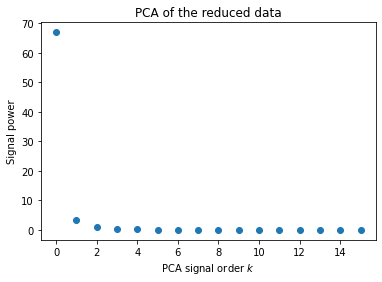


HopeLim = 168.31740627613874
PCA_red 17= 65.21650693935396


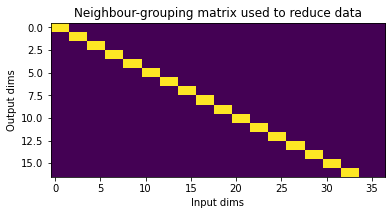

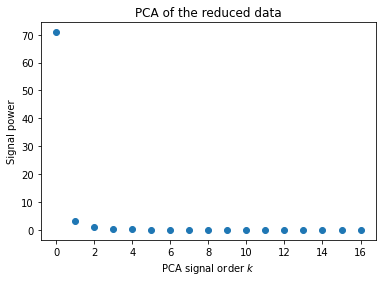


HopeLim = 168.43517420621419
PCA_red 18= 71.35830207625855


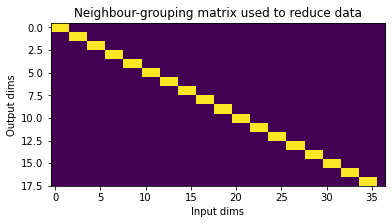

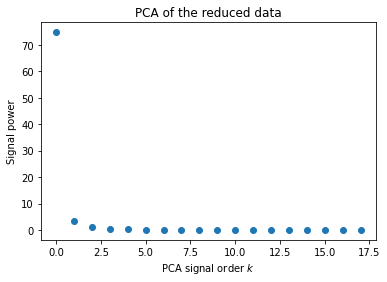


HopeLim = 156.50663874577538
PCA_red 19= 29.72877662293198


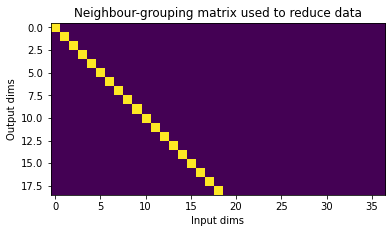

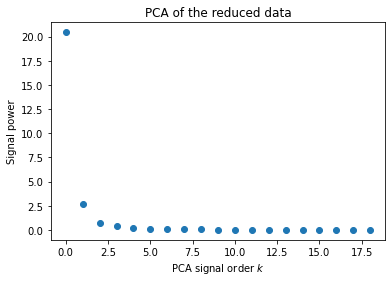


HopeLim = 190.41008667001287
PCA_red 20= 32.081692187854756


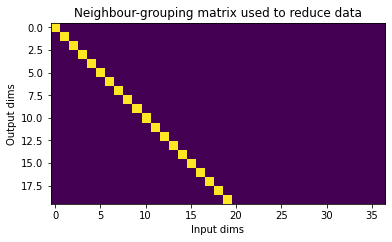

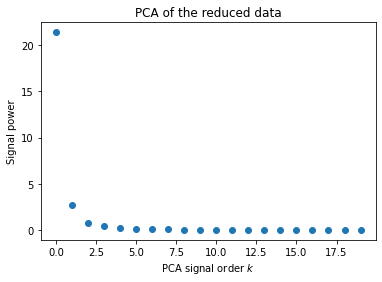


HopeLim = 191.84860244754097
PCA_red 21= 34.07814245744781


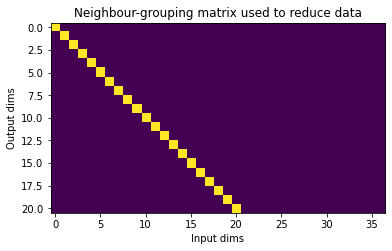

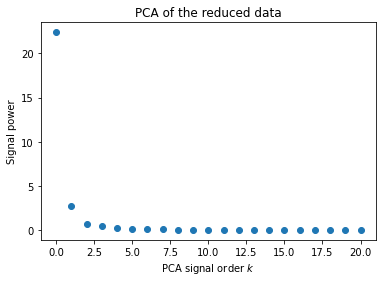


HopeLim = 203.98005824384254
PCA_red 22= 36.45134862646218


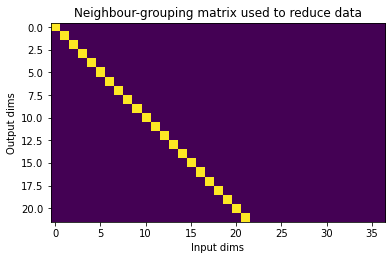

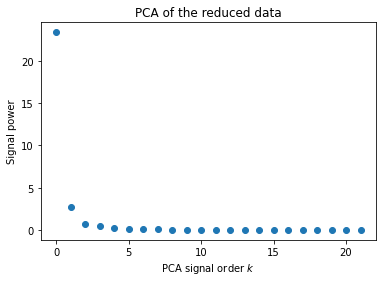


HopeLim = 220.21576906486746
PCA_red 23= 38.51022278722898


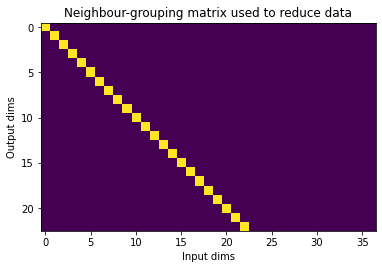

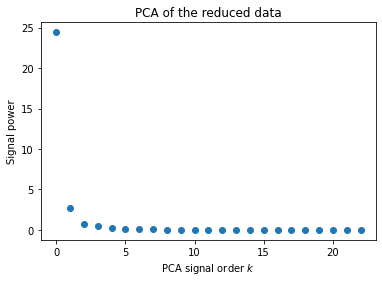


HopeLim = 223.31059485899712
PCA_red 24= 40.5459908199833


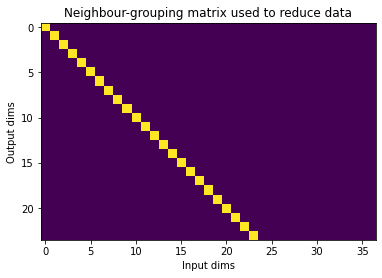

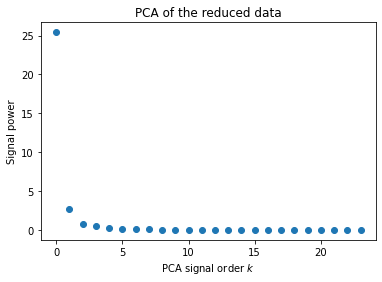


HopeLim = 260.2369445637304
PCA_red 25= 42.998680110941045


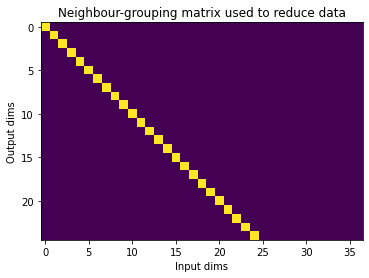

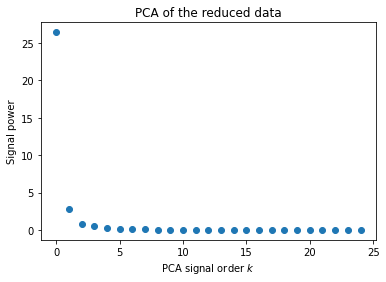


HopeLim = 261.0036428987013
PCA_red 26= 45.895043909967995


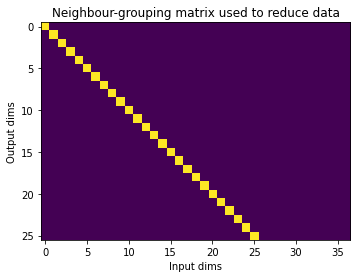

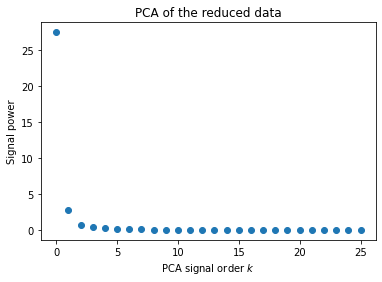


HopeLim = 268.1338978967539
PCA_red 27= 47.75309153539811


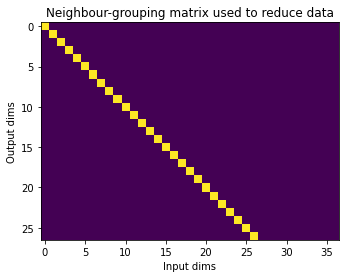

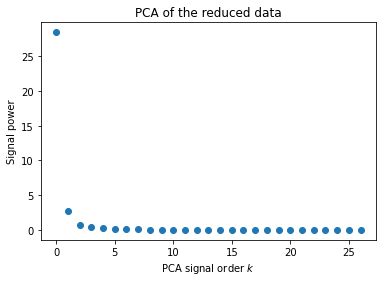


HopeLim = 301.93562929158236
PCA_red 28= 50.22122428069351


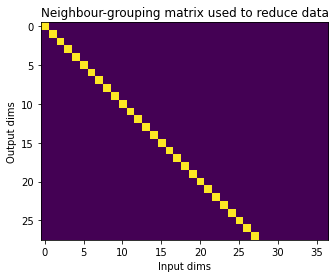

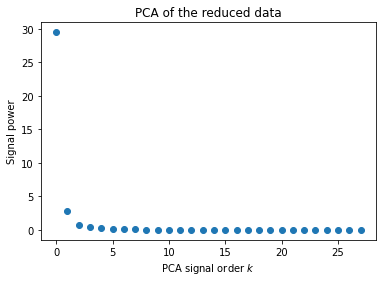


HopeLim = 303.76640888544165
PCA_red 29= 52.94638377888817


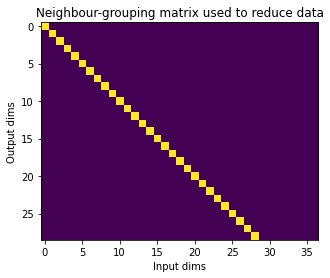

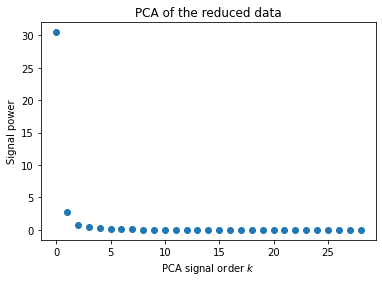


HopeLim = 307.18955315395533
PCA_red 30= 55.14461357609945


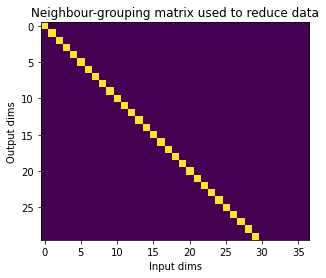

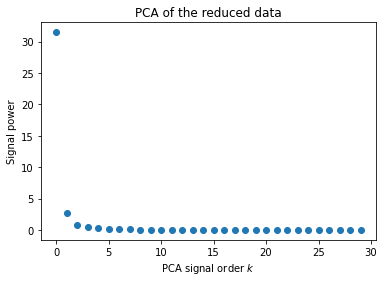


HopeLim = 308.441192999415
PCA_red 31= 56.80611032509516


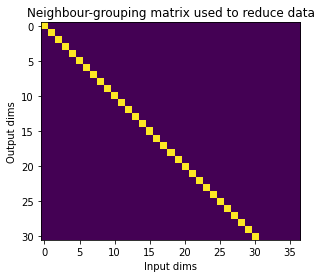

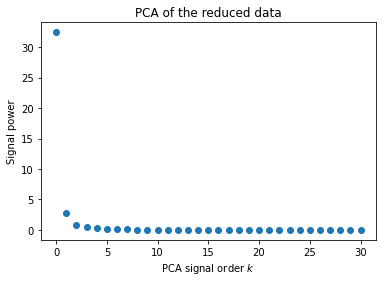


HopeLim = 320.38025694775496
PCA_red 32= 59.00816506658069


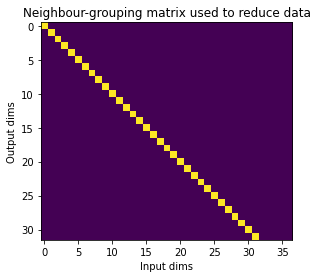

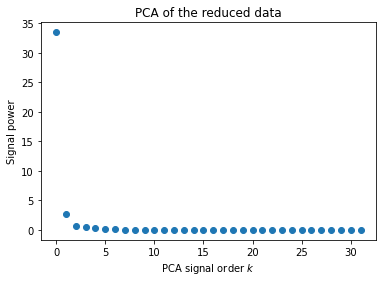


HopeLim = 322.6086618660793
PCA_red 33= 61.6137492492602


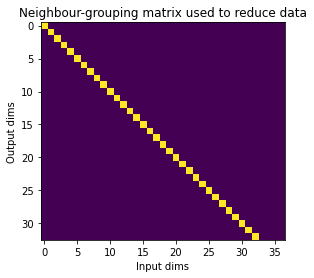

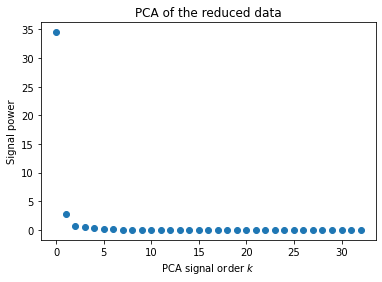


HopeLim = 420.8365887414772
PCA_red 34= 64.79357832594897


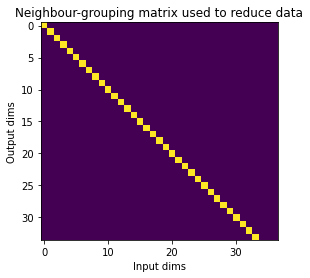

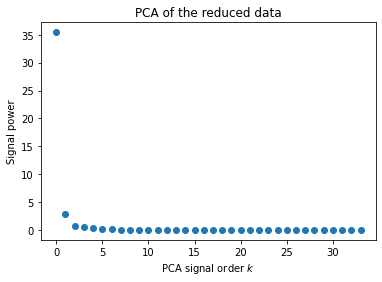


HopeLim = 423.2059976621957
PCA_red 35= 67.43588287600636


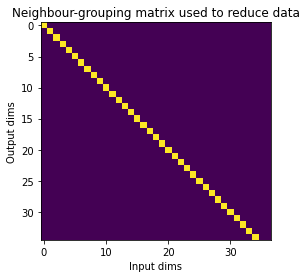

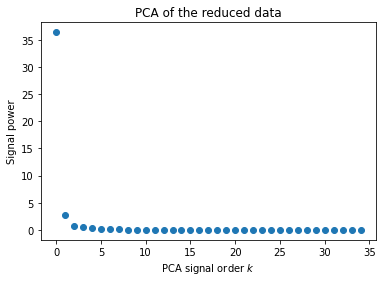


HopeLim = 423.40948682937886
PCA_red 36= 70.91558149708426


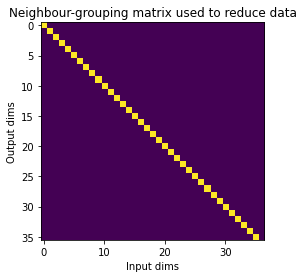

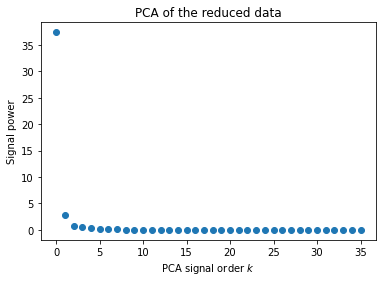


HopeLim = 525.2587191125513
PCA_red 37= 73.17702751214452


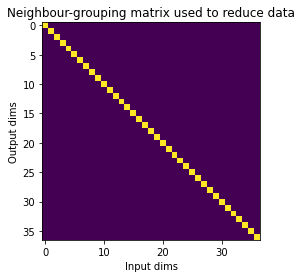

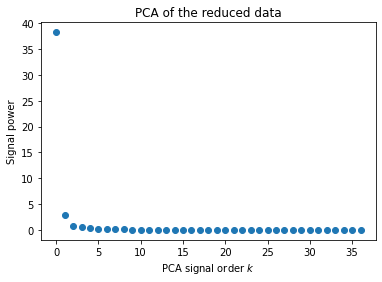

In [110]:


for i in range(1,d+1):
    d_out = i
    
    red = avg_dim_reductor(d, d_out)
    rv_w, Whiten_mat, Whiten_mat_inv, eigs_RY_2 = whiten(red.dot(rv))
    
    sol = minimize(lambda combs: np.sum((combs.dot(rv_w)-standardize(theo[ind]))**2), np.ones(len(rv_w)))
    print('\nHopeLim =', SNR(standardize(theo[ind]), sol.x.dot(rv_w)))
    print('PCA_red '+str(i ) +'=', SNR(standardize(theo[ind]), standardize(np.sign(standardize(theo[ind]).dot(rv_w[0,:]))*rv_w[0,:])))
    plt.figure()
    plt.title('Neighbour-grouping matrix used to reduce data')
    plt.xlabel('Input dims')
    plt.ylabel('Output dims')
    plt.imshow(red)
    plt.show()


    plt.figure()
    plt.title('PCA of the reduced data')
    plt.scatter(range(len(rv_w)), eigs_RY_2)
    plt.xlabel(r'PCA signal order $k$')
    plt.ylabel(r'Signal power')
    plt.show()


    


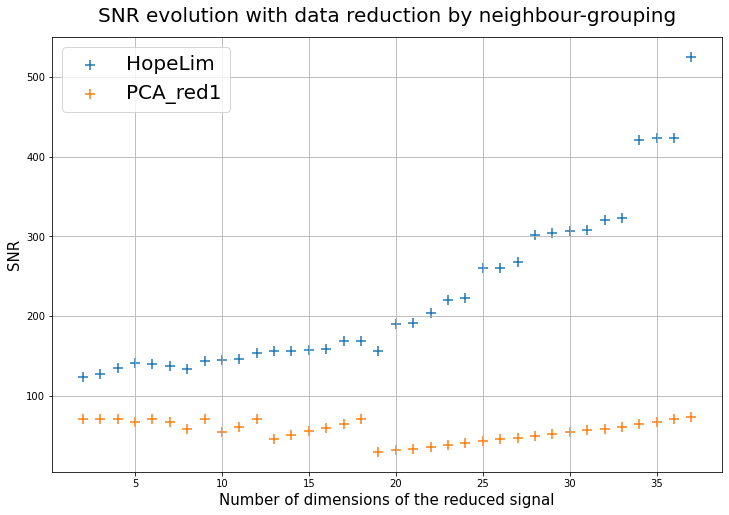

In [111]:
dims = range(2, d+1)
hopes = []
PCAs_red1 = []

for d_out in dims:
    #print("\nReducting to ", d_out, " dims:")
    red = avg_dim_reductor(d, d_out)
    rv_w, Whiten_mat, Whiten_mat_inv, eigs_RY_2 = whiten(red.dot(rv))
    sol = minimize(lambda combs: np.sum((combs.dot(rv_w[:d_out,:])-standardize(theo[ind]))**2), np.ones(len(rv_w[:d_out,:])))
    hope = SNR(standardize(theo[ind]), sol.x.dot(rv_w[:d_out,:]))
    PCA_red1 = SNR(standardize(theo[ind]), standardize(np.sign(standardize(theo[ind]).dot(rv_w[0,:]))*rv_w[0,:]))
    hopes.append(hope)
    PCAs_red1.append(PCA_red1)
    #print('---- HopeLim =', hope)
    #print('---- PCA_red1 =', PCA_red1)

plt.figure(figsize=(12,8))
plt.scatter(dims, hopes, marker='+', s=100, label='HopeLim')
plt.scatter(dims, PCAs_red1, marker='+', s=100, label='PCA_red1')
plt.legend(fontsize=20)
plt.grid(True)
plt.xlabel('Number of dimensions of the reduced signal', fontsize=15)
plt.ylabel('SNR', fontsize=15)
plt.title('SNR evolution with data reduction by neighbour-grouping', fontsize=20, pad=15)
plt.show()

## Analyze through ICA with only one run

First reduce dimension. Here we choose to target 6 but this is arbitrary and such decisions will be made automatically later when using stochastic ICA.

In [112]:
d_out = 4
red = avg_dim_reductor(d, d_out)
rv_w, Whiten_mat, Whiten_mat_inv, eigs_RY_2 = whiten(red.dot(rv))

In [122]:
customICA = CustomICA(rv_w,
                      noise_fraction=10/100,
                      verbose=False, 
                      constraints=['less-entropy'],
                      schedule=[sk_FastICA],
                      schedule_kwargs=[{'max_iter':1000, 'algorithm':'deflation'}],
                      skip_exception=False)


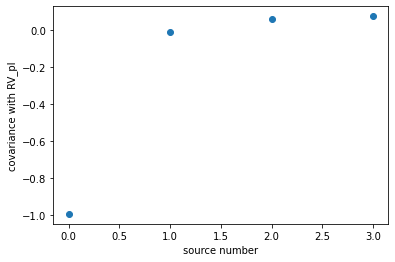


HopeLim = 135.42261187024314
RV_pl identified with source number 0
Resulting SNR = 61.937474486002415


In [124]:
S_hat = customICA.result_traceback[-1]['S']


objective = standardize(theo[ind])
sol = minimize(lambda combs: np.sum((combs.dot(S_hat)-objective)**2), np.ones(len(S_hat)))

plt.figure()
plt.scatter(range(len(sol.x)), sol.x)
plt.xlabel('source number')
plt.ylabel('covariance with RV_pl')
plt.show()
print('\nHopeLim =', SNR(objective, sol.x.dot(S_hat)))
best_ind = np.abs(sol.x).argmax()
print('RV_pl identified with source number', best_ind)
print('Resulting SNR =', SNR(objective, standardize(np.sign(sol.x[best_ind])*S_hat[best_ind])))

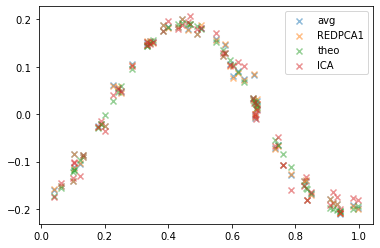

In [125]:
plt.scatter(t/period % 1, standardize(obs_avg), label='avg', marker='x', alpha=0.5)
plt.scatter(t/period % 1, standardize(np.sign(standardize(theo[ind]).dot(rv_w[0,:]))*rv_w[0,:]), label='REDPCA1', marker='x', alpha=0.5)
plt.scatter(t/period % 1, standardize(theo[ind]), label='theo', marker='x', alpha=0.5)
plt.scatter(t/period % 1, standardize(np.sign(sol.x[best_ind])*S_hat[best_ind]), label='ICA', marker='x', alpha=0.5)
plt.legend()

## Using stochastic ICA with post-processing

In [128]:
steps = 10

# Specifying the proxy to use:
target = standardize(obs_avg)

# Specify the range of dimensions to explore
target_source_num = list(range(2,6))

In [129]:
#%%capture
def ICA_try(l):
    print('Computing with neighbour-grouping in ',l, ' dimensions...')
    try:
        return CustomICA(whiten(mean(avg_dim_reductor(d, l).dot(rv))[0])[0],
                         noise_fraction=10/100,
                         verbose=False, 
                         constraints=['less-entropy'],
                         num_sources=l,
                         schedule=steps*[sk_FastICA],
                         schedule_kwargs=steps*[{'max_iter':1000, 'algorithm':'deflation'}],
                         skip_exception=False)
    except Exception as error:
        print(error)
        pass
    
ICA_trys = [ICA_try(l) for l in target_source_num]

Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing with neighbour-grouping in  4  dimensions...
Computing with neighbour-grouping in  5  dimensions...
Computing with neighbour-grouping in  6  dimensions...


In [130]:
for _ in range(10):
    ICA_trys += [ICA_try(l) for l in target_source_num]

Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing with neighbour-grouping in  4  dimensions...
Computing with neighbour-grouping in  5  dimensions...
Computing with neighbour-grouping in  6  dimensions...
Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing with neighbour-grouping in  4  dimensions...
Computing with neighbour-grouping in  5  dimensions...
Computing with neighbour-grouping in  6  dimensions...
Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing with neighbour-grouping in  4  dimensions...
Computing with neighbour-grouping in  5  dimensions...
Computing with neighbour-grouping in  6  dimensions...
Computing with neighbour-grouping in  2  dimensions...
Computing with neighbour-grouping in  3  dimensions...
Computing with neighbour-grouping in  4  dimensions...
Computing 

In [131]:
postProcess = PostProcess(ICA_trys, target)

In [132]:
def threshold_grading(target_corr, entropy):
    '''A way to grade an ICA run only using the correlation between the identified source and the proxy'''
    if abs(target_corr)<0.93:
        return 0
    else:
        return 1

Guess out of 2 sources, epoch=550 relative error:  0.9740136579365847 %  SNR:  102.66796485364142
Guess out of 3 sources, epoch=550 relative error:  1.0462921416874076 %  SNR:  95.57560074830057
Guess out of 4 sources, epoch=550 relative error:  0.966497129559491 %  SNR:  103.46642213575728
Guess out of 5 sources, epoch=550 relative error:  3.3780586957820478 %  SNR:  29.60280119610213
Guess out of 6 sources, epoch=550 relative error:  6.516545536329168 %  SNR:  15.345553781909263
Guess full, epoch=550 relative error:  1.1716331404224936 %  SNR:  85.3509486458703
Guess best, epoch= 550  cov= 0.9975897155642321  entropy= 0.029910988289526225  relative error:  0.8075025428392704 %  SNR:  123.83861931677478
Target relative error:  1.3374179635438823 %  SNR:  74.77094126582581


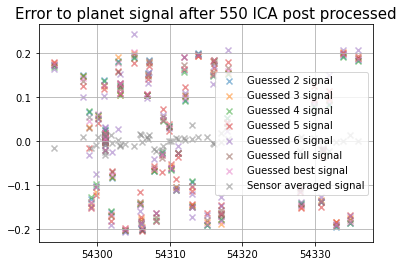

In [133]:
fig = postProcess.investigate(standardize(theo[ind]),
                              plot_timeline=t, plot_title='planet',
                              amplifier=threshold_grading)

In [136]:
ICA_res = postProcess.post_process(amplifier=threshold_grading)
#On corrige avec le facteur
ICA_res *= np.array(metadata['RV theo'])[ind].dot(np.array(metadata['RV theo'])[ind]) \
           * 1 / np.array(metadata['RV theo'])[ind].dot(ICA_res)

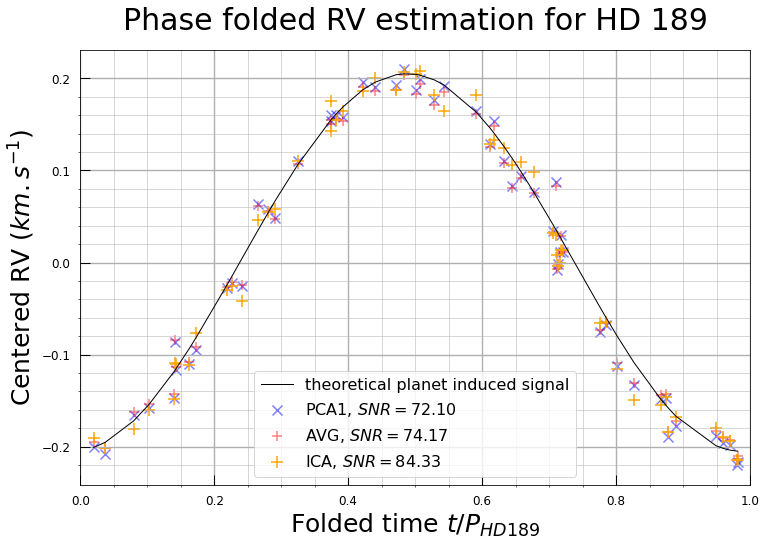

In [137]:
alpha = 0.5
phase = 0.04
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_yticks(np.linspace(-.22,.2,22), minor=True)
ax.set_xticks(np.linspace(0,1,21), minor=True)
plt.grid(True, which='minor', linewidth=0.5)
plt.grid(True, which='major', linewidth=1.4)
plt.xlim(0,1)
plt.tick_params(length=10, width=1, direction='in', pad=10, labelsize='large')
inds = np.argsort((t/period + phase) % 1)
plt.plot(((t/period + phase)% 1 )[inds], np.array(metadata['RV theo'])[ind][inds], linewidth=1, color='black', label=r'theoretical planet induced signal')
plt.scatter((t/period + phase)%1, PCA1, s=100, color='blue', marker='x', alpha=alpha,\
            label=r'PCA1, $SNR={:.2f}$'.format(SNR(np.array(metadata['RV theo'])[ind], PCA1)))
plt.scatter((t/period + phase)%1, obs_avg, s=100, color='red', marker='+', alpha=alpha, \
            label=r'AVG, $SNR={:.2f}$'.format(SNR(np.array(metadata['RV theo'])[ind], obs_avg)))
plt.scatter((t/period + phase)%1, ICA_res, s=150, color='orange', marker='+', alpha=1, \
            label=r'ICA, $SNR={:.2f}$'.format(SNR(np.array(metadata['RV theo'])[ind], ICA_res)))
#plt.errorbar(t/period % 1, obs_avg, 10**-1*np.average(sigma, axis=0)/sigma.shape[0]**.5, fmt='o')
plt.ylabel(r'Centered RV $(km.s^{-1})$', fontsize=25)
plt.legend(fontsize=16)
plt.xlabel(r'Folded time $t/P_{HD189}$', fontsize=25)
plt.title(r'Phase folded RV estimation for HD 189', fontsize=30, pad=20)
#plt.savefig('HD189_phase_fold.png', dpi=200)
plt.show()

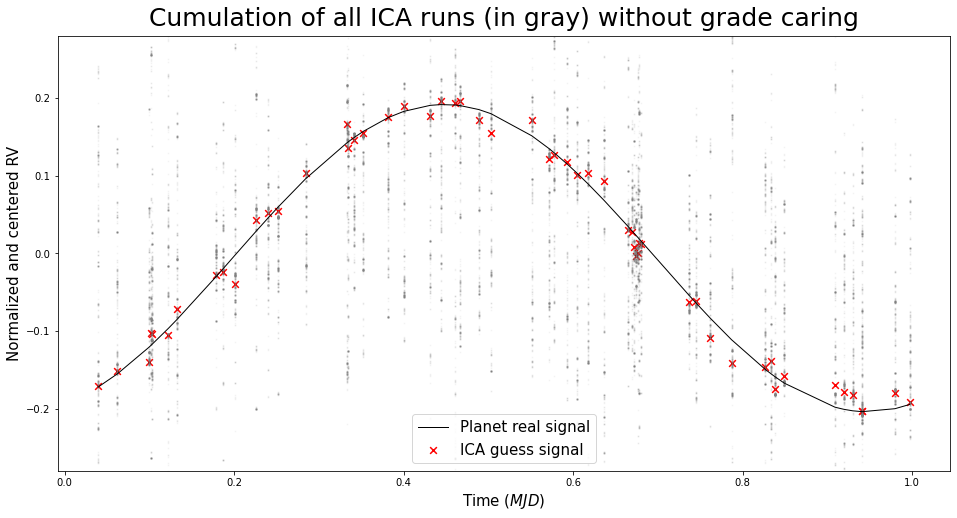

In [138]:
plt.figure(figsize=(16,8))
inds = np.argsort(t/period % 1)
plt.plot((t/period % 1)[inds], standardize(theo[ind])[inds], linewidth=1, color='black', label='Planet real signal')
plt.scatter(t/period % 1, postProcess.post_process(threshold_grading), s=45, color='red', marker='x', label='ICA guess signal')
for l in postProcess.num_sources_list:
    for signal, grade in zip(postProcess.signals[l], postProcess.grades[l]):
        plt.scatter(t/period % 1, signal, s=1, color='gray', alpha=0.05)
#plt.scatter(t/period % 1, postProcess.target, s=45, color='blue', marker='x', label='RV avareged over sensors')
plt.legend(fontsize=15, loc='lower center')
plt.title('Cumulation of all ICA runs (in gray) without grade caring', fontsize=25, pad=10)
plt.xlabel(r'Time $(MJD)$', fontsize=15)
plt.ylabel(r'Normalized and centered RV', fontsize=15)
plt.ylim((-0.28,0.28))
#plt.savefig('results/cumaltion_ICA_basic.png', dpi=200, bbox_inches='tight')
plt.show()

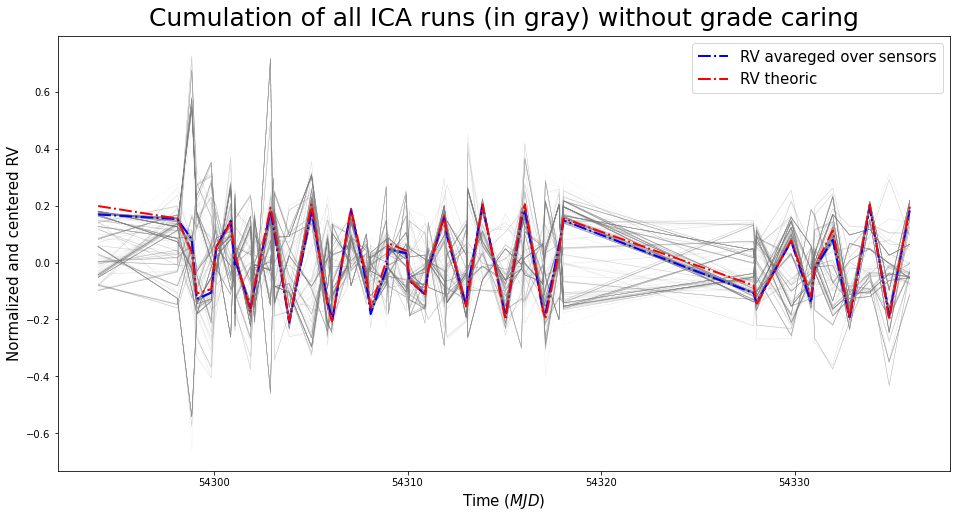

In [139]:
plt.figure(figsize=(16,8))
for l in postProcess.num_sources_list:
    plt.plot(t, postProcess.signals[l].T, linewidth=0.4, color='gray', alpha=0.1)
plt.plot(t, postProcess.target, linestyle='-.', linewidth=2, color='blue', label='RV avareged over sensors')
plt.plot(t, metadata['RV theo'][ind], linestyle='-.', linewidth=2, color='red', label='RV theoric')
plt.legend(fontsize=15)
plt.title('Cumulation of all ICA runs (in gray) without grade caring', fontsize=25, pad=10)
plt.xlabel(r'Time $(MJD)$', fontsize=15)
plt.ylabel(r'Normalized and centered RV', fontsize=15)
#plt.savefig('results/cumaltion_ICA_basic.png', dpi=200, bbox_inches='tight')
plt.show()

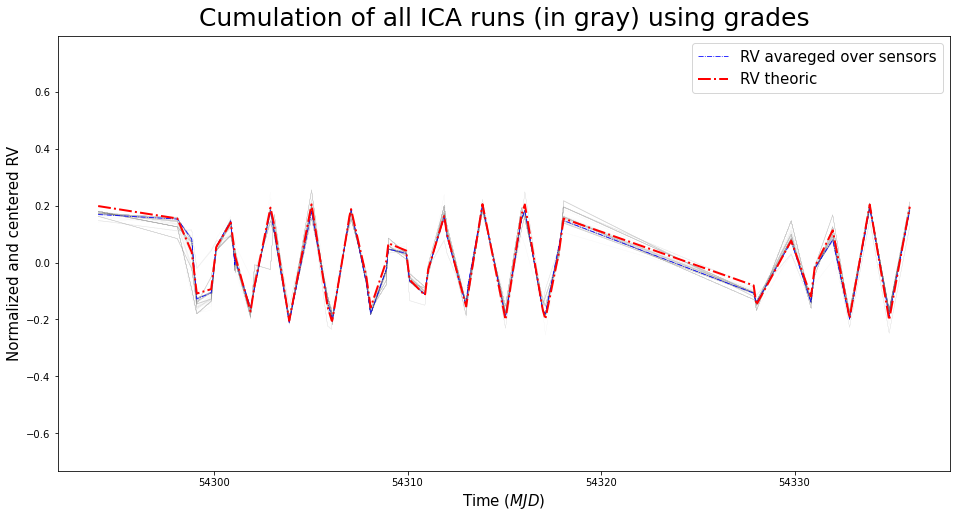

In [140]:
plt.figure(figsize=(16,8))

for l in postProcess.num_sources_list:
    for signal, grade in zip(postProcess.signals[l], postProcess.grades[l]):
        plt.plot(t, signal, linewidth=2*np.tanh(0.01*grade), color='gray', alpha=0.5)
plt.plot(t, postProcess.target, linestyle='-.', linewidth=0.8, color='blue', label='RV avareged over sensors')
plt.plot(t, metadata['RV theo'][ind], linestyle='-.', linewidth=2, color='red', label='RV theoric')
plt.legend(fontsize=15)
plt.title('Cumulation of all ICA runs (in gray) using grades', fontsize=25, pad=10)
plt.xlabel(r'Time $(MJD)$', fontsize=15)
plt.ylabel(r'Normalized and centered RV', fontsize=15)
#plt.savefig('results/cumaltion_ICA_grades.png', dpi=200, bbox_inches='tight')
plt.show()

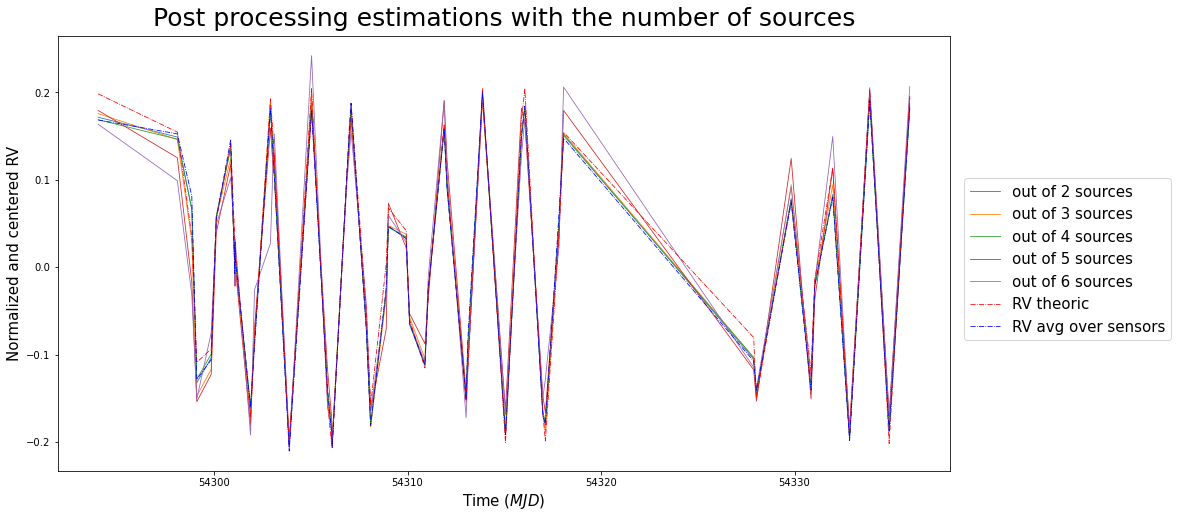

In [141]:
plt.figure(figsize=(16,8))
for l in postProcess.num_sources_list:
    guess = postProcess.post_process(amplifier=threshold_grading, select_l=l)
    plt.plot(t, guess, linestyle='-', linewidth=0.8, label='out of '+str(l)+' sources')
plt.plot(t, metadata['RV theo'][ind], linestyle='-.', linewidth=0.8, color='red', label='RV theoric')    
plt.plot(t, postProcess.target, linestyle='-.', linewidth=0.8, color='blue', label='RV avg over sensors')
plt.legend(fontsize=15, ncol=1, loc=(1.015,0.3))
plt.title('Post processing estimations with the number of sources', fontsize=25, pad=10)
plt.xlabel(r'Time $(MJD)$', fontsize=15)
plt.ylabel(r'Normalized and centered RV', fontsize=15)
#plt.savefig('results/postprocessing_ICA_various.png', dpi=200, bbox_inches='tight')
plt.show()

In [142]:
def fit_to_sinus(timeline, guess, P=period, steps=1000, name=None):
    phi = np.linspace(0,2*np.pi, steps)
    preds = np.sin(2*np.pi*np.stack(steps*(timeline,), -1)/P + np.stack(len(timeline)*(phi,), 0))
    preds /= np.diag(preds.T.dot(preds))**.5
    
    diffs = np.average((np.stack(steps*(guess,),-1) - preds)**2, axis=0)
    ind = diffs.argmin()
    phi_opt = phi[ind]
    preds = preds[:,ind]
    
    smooth_times = np.linspace(timeline[0], timeline[-1], steps)
    smooth_preds = np.sin(2*np.pi*smooth_times/P + phi_opt)
    smooth_preds /= (len(timeline)/steps*smooth_preds.dot(smooth_preds.T))**.5
    
    err = np.average((guess-preds)**2)/np.average(preds**2)
    fig = plt.figure(figsize=(12,6))
    plt.scatter(timeline, guess, marker='x', color='red')
    plt.plot(smooth_times, smooth_preds, color='gray')
    plt.title(name+' error to sinus model: {:.3f}%'.format(100*err), fontsize=20, pad=10)
    plt.xlabel(r'Time $(MJD)$', fontsize=15)
    plt.ylabel(r'Normalized and centered RV', fontsize=15)
    plt.show()
    
    return preds, smooth_times, smooth_preds

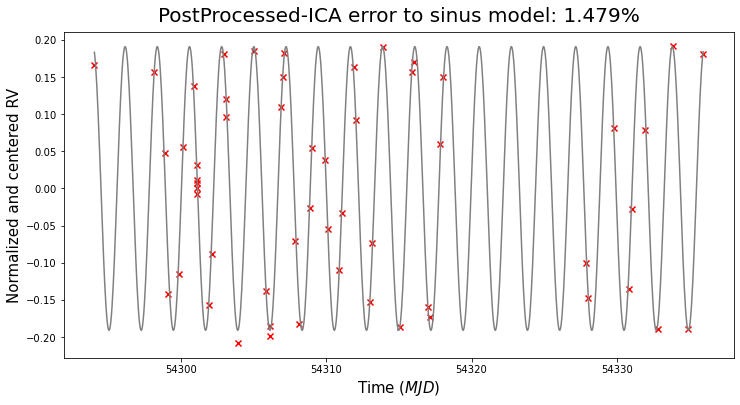

In [80]:
preds, smooth_times, smooth_preds = fit_to_sinus(t, 
                                                 postProcess.post_process(amplifier=threshold_grading),
                                                 name='PostProcessed-ICA')

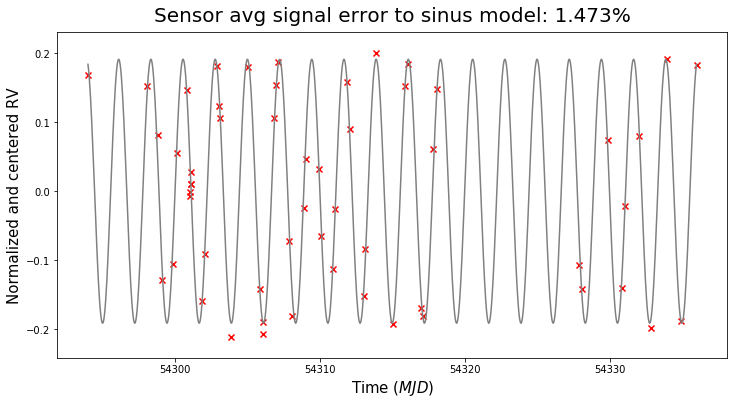

In [79]:
preds, smooth_times, smooth_preds = fit_to_sinus(t, 
                                                 postProcess.target,
                                                 name='Sensor avg signal')

## \<center\>Questions left
    - How to compute covariance/independence of a time series that is not stationnary?
    - How to derive and what can be said about the stellar activity when doing stochastic ICA?
    - Is the number of time points affecting the SNR estimation?